In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [3]:
%%capture
import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

In [4]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name): 
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"

# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [6]:
# Maximum samples count for padding purposes.

sample_lengths = []
folder_path = '/content/drive/My Drive/AudioFiles'

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)
     
    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))  

Maximum sample length: 243200


In [5]:
#preprocess

import time
tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 243200*2 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = '/content/drive/My Drive/AudioFiles' 

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 

    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 0) 
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
      print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed-- 
    # Pad for duration equalization.
      padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')
    # Noise reduction.
      final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22
       
   # Features extraction 
      f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
      f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
      f3 = librosa.feature.mfcc(final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
      
   # Emotion extraction from the different databases
      if (find_emotion_T(file) != "-1"): #TESS database validation
            name = find_emotion_T(file)
      else:                              #RAVDESS database validation
            name = file[6:8]                      

   # Filling the data lists  
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotionfix(name)) 

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

03-02-02-01-01-02-20.wav 	 153600 	 -41.522344822589105 	 -15.363870750351472
03-02-01-01-01-01-20.wav 	 133120 	 -38.59978410902434 	 -14.948082417146022
03-02-02-01-02-01-20.wav 	 141312 	 -40.4537909186576 	 -15.72732355832212
03-02-02-01-01-01-20.wav 	 141824 	 -44.24507755078458 	 -16.176349681728464
03-02-01-01-01-02-20.wav 	 126464 	 -39.182948683848615 	 -15.438803404625762
03-02-02-01-02-02-20.wav 	 146432 	 -39.91243882367998 	 -15.95891720391032
03-02-01-01-02-01-20.wav 	 130560 	 -38.75916270244985 	 -15.818566156823104
03-02-01-01-02-02-20.wav 	 129536 	 -38.851566655184754 	 -14.73440021927212
03-02-02-02-01-02-20.wav 	 155136 	 -42.455059634001046 	 -17.127797254375594
03-02-03-02-02-02-20.wav 	 117760 	 -25.563151947845185 	 -18.64956011709824
03-02-03-02-01-02-20.wav 	 109568 	 -24.103631366545404 	 -19.580355182754086
03-02-02-02-01-01-20.wav 	 169472 	 -42.81403177899228 	 -17.4834835545561
03-02-03-01-01-01-20.wav 	 128000 	 -33.878728131098896 	 -16.926381751727707

In [6]:
# Adjusting features shape to the 3D format: (batch, timesteps, feature)

f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (3812, 951, 1)
RMS shape: (3812, 951, 1)
MFCCs shape: (3812, 951, 13)


In [7]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [8]:
# Save X,Y arrays as lists to json files.

x_data = X.tolist() 
x_path = '/content/drive/My Drive/Colab Notebooks/X_datanew.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist() 
y_path = '/content/drive/My Drive/Colab Notebooks/Y_datanew.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)

'[[1], [0], [1], [1], [0], [1], [0], [0], [1], [2], [2], [1], [2], [2], [2], [1], [2], [2], [2], [1], [3], [3], [3], [3], [4], [3], [3], [3], [3], [4], [4], [4], [5], [4], [5], [4], [4], [5], [4], [5], [5], [5], [5], [5], [0], [0], [0], [1], [0], [2], [1], [1], [1], [2], [2], [1], [1], [1], [1], [2], [2], [3], [2], [2], [3], [3], [3], [3], [3], [2], [3], [5], [4], [4], [4], [3], [4], [4], [4], [4], [5], [5], [4], [5], [5], [5], [5], [5], [0], [1], [1], [0], [0], [1], [1], [0], [1], [1], [2], [2], [2], [1], [2], [1], [2], [2], [2], [3], [3], [2], [3], [4], [3], [4], [3], [3], [3], [3], [5], [5], [4], [4], [5], [5], [4], [4], [5], [4], [4], [5], [5], [5], [1], [0], [1], [1], [1], [1], [0], [1], [1], [0], [0], [1], [2], [2], [3], [2], [2], [3], [2], [3], [3], [2], [2], [3], [2], [4], [3], [4], [3], [3], [4], [4], [4], [4], [4], [4], [5], [5], [5], [5], [5], [5], [5], [5], [0], [0], [0], [0], [1], [2], [1], [2], [1], [1], [1], [1], [1], [1], [2], [3], [3], [3], [2], [3], [2], [2], [2], [2]

In [9]:
# Load X,Y json files back into lists, convert to np.arrays

x_path = '/content/drive/My Drive/Colab Notebooks/X_datanew.json' # FILE LOAD PATH
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = '/content/drive/My Drive/Colab Notebooks/Y_datanew.json' # FILE LOAD PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [10]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

In [52]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))
print(np.shape(y_val))

(3335, 951, 15)
(331, 951, 15)
(146, 951, 15)
(331, 1)


In [12]:
# Save x_test, y_test to JSON.

file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[3], [0], [5], [2], [5], [0], [4], [1], [2], [0], [2], [2], [5], [2], [3], [1], [7], [7], [3], [2], [5], [6], [7], [2], [3], [6], [1], [0], [4], [2], [3], [5], [4], [7], [7], [5], [5], [7], [4], [4], [2], [5], [2], [2], [3], [1], [3], [3], [2], [7], [0], [3], [3], [4], [0], [3], [4], [6], [4], [4], [6], [5], [1], [0], [6], [6], [2], [1], [7], [2], [3], [0], [3], [7], [5], [2], [1], [0], [0], [2], [6], [4], [4], [4], [6], [0], [3], [0], [0], [3], [4], [5], [2], [6], [0], [7], [5], [5], [2], [4], [3], [2], [1], [2], [2], [3], [2], [7], [5], [3], [7], [0], [5], [5], [5], [6], [3], [4], [6], [3], [6], [1], [6], [2], [0], [3], [3], [4], [4], [5], [4], [2], [3], [6], [2], [2], [6], [3], [3], [2], [5], [4], [5], [2], [7], [6]], "dtype": "int8", "shape": [146, 1], "Corder": true}'

In [13]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

In [14]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)
                             
# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class, 
                      epochs=340, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 951, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 54,024
Trainable params: 54,024
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/340
145/145 [==============================] - 16s 61ms/step - loss: 1.9944 - categorical_accuracy: 0.1790 - val_loss: 1.9167 - val_categorical_accuracy: 0.2477 - lr: 0.0010
Epoch 2/340
145/145 [==============================] - 8s 56ms/step - loss: 1.8094 - categorical_accuracy: 0.2660 - val_loss: 1.8

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

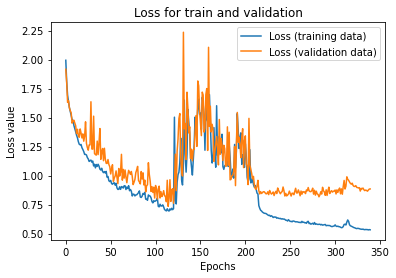

In [19]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

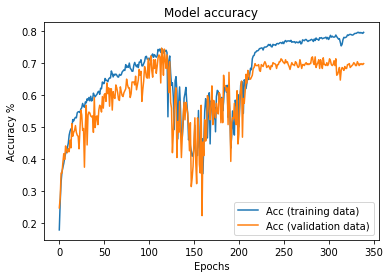

In [35]:
#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Accuracy %')
plt.xlabel('Epochs')
plt.legend(loc="lower right")
plt.show()

In [25]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

11/11 - 0s - loss: 0.7348 - categorical_accuracy: 0.7462 - 438ms/epoch - 40ms/step


In [54]:
print(np.shape(y_val_class))

()


In [62]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(saved_weights_path)
print("Saved model to disk")

Saved model to disk


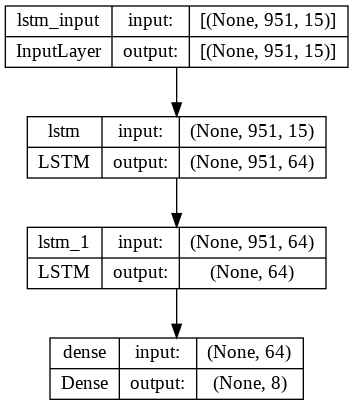

In [63]:
# Reading the model from JSON file

saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [64]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 8, dtype = 'int8')

In [65]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

5/5 - 1s - loss: 0.7405 - categorical_accuracy: 0.7329 - 1s/epoch - 290ms/step


5/5 [==============================] - 1s 46ms/step


Text(0.5, 51.0, 'Predicted emotion')

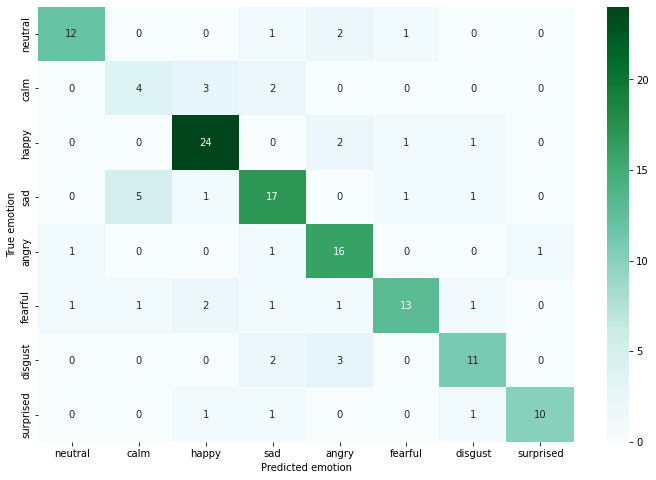

In [66]:
# Test set Confusion matrix

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

5/5 [==============================] - 0s 46ms/step


Text(0.5, 51.0, 'Predicted emotion')

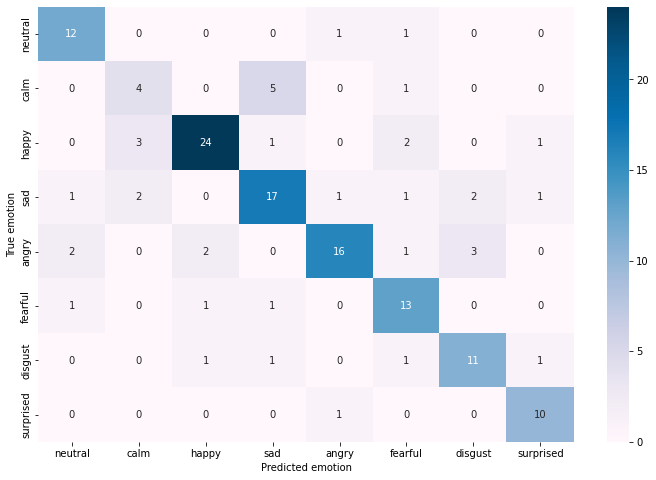

In [76]:
# Validation Confusion matrix

#y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_pred_class, y_test_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [77]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.8571
calm : 0.4000
happy : 0.7742
sad : 0.6800
angry : 0.6667
fearful : 0.8125
disgust : 0.7333
surprised : 0.9091


In [78]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 0.8571
calm : 0.4000
happy : 0.7742
sad : 0.6800
angry : 0.6667
fearful : 0.8125
disgust : 0.7333
surprised : 0.9091
